# Clustering Algorithms on Amazon Fine Food Reviews 

## [ CONTENTS ] 

1. About the dataset<br>
2. Objective<br>
3. Loading the data<br>
4. Data Preprocessing <br>
5. Function Definitions<br>
6. Bag of Words (BoW)<br>
7. TF-IDF<br>
8. Word2Vec<br>
9. Avg W2V & TFIDF-W2V<br>
    9.1 TF-IDF weighted W2V
10. Summary<br>

## 1. About the dataset
1. Title: Amazon Fine Food Reviews. Link:https://www.kaggle.com/snap/amazon-fine-food-reviews
2. Relevant Information: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.
3. Data includes:
    * Number of reviews: 568,454<br>
    * Number of users: 256,059<br>
    * Number of products: 74,258<br>
    * Timespan: Oct 1999 - Oct 2012<br>
    * Number of Attributes/Columns in data: 10 
4. Attribute Information: 
    * Id
    * ProductId - unique identifier for the product
    * UserId - unqiue identifier for the user
    * ProfileName
    * HelpfulnessNumerator - number of users who found the review helpful
    * HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
    * Score - rating between 1 and 5
    * Time - timestamp for the review
    * Summary - brief summary of the review
    * Text - text of the review

## 2. Objective:
For given Amazon reviews, cluster them into groups using unsupervised algorithms.<br>
<br>
Here I'm using various clustering algorithms(K-means, K-medoid, Hirarchical, DBSCAN) to cluster the reviews into different groups. To convert a review text to numerical features I'm using bag of words(BoW), TF-IDF, Word2Vec and TF-IDF weighted Word2Vec. 

In [1]:
# importing required libraries
import numpy as np
import pandas as pd 
import matplotlib 
import sqlite3
import string
import nltk
import time
from matplotlib import pyplot as plt 
import seaborn as sns 
from scipy import stats
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale, minmax_scale

#Standardizing the data
def standardizer(data):
    stnd_scaler = StandardScaler(with_mean=False)
    stnd_matx = stnd_scaler.fit_transform(data)
    return stnd_matx

## 3. Loading the data

In [3]:
# Loading the previously cleaned data
connect = sqlite3.connect('final_data.sqlite')

#Ignoring the rows which have rating 3
data = pd.read_sql_query("""
SELECT *
FROM Reviews
""", connect)

In [4]:
data.shape

(364171, 12)

In [5]:
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...
2,138689,150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...,b'fun way children learn month year learn poem...
3,138690,150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...,b'great littl book read nice rhythm well good ...
4,138691,150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...,b'book poetri month year goe month cute littl ...


## 4. Data Preprocessing

In [6]:
sorted_data = data.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [7]:
sorted_data.head(5)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...
424,417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,positive,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,b'beetlejuic well written movi everyth excel a...
330,346055,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,positive,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta...",b'twist rumplestiskin captur film star michael...
423,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,b'beetlejuic excel funni movi keaton hilari wa...


## 5. Function Definitions

### 5.1. K-Means Clustering

In [8]:
def kmean_cluster(data, vectorizer, name):
    
    fit_models = []
    num_clusters = np.arange(10, 51, 5)
    if name in ['BoW','TFIDF']:
                
        vect = standardizer(vectorizer.fit_transform(data['CleanedText'].values))
        for i in num_clusters:
            clf = KMeans(n_clusters = i, n_init = 8, n_jobs = -1) 
            clf.fit(vect)
            fit_models.append(clf)

    elif name == 'Word2Vec':
                
        w2v_model = gensim.models.Word2Vec(data, min_count=5, size=100, workers=-1)
        w2v_vect = avg_w2v(data, w2v_model)
        
        for i in num_clusters:
            clf = KMeans(n_clusters = i, n_init = 8, n_jobs = -1) 
            clf.fit(w2v_vect)
            fit_models.append(clf)
                
    else:
                
                raw_x = vectorizer # its the text data n't a vectorizer for tfidf-w2v 
                X1 = np.array(X)
                w2v_model = gensim.models.Word2Vec(X1[train], min_count=5, size=100, workers=-1)
                tfidf_dict = tf_idf_vect.fit_transform(raw_x[train])
                train_vect = tfidf_w2v(X[cv.shape[0]:], w2v_model, tfidf_dict)
                cv_vect = tfidf_w2v(X[:cv.shape[0]], w2v_model, tfidf_dict)
                
                train_vect = np.nan_to_num(train_vect)
                cv_vect = np.nan_to_num(cv_vect)
            
                clf = DecisionTreeClassifier(max_depth=d, criterion='gini', class_weight='balanced') 
                clf.fit(standardizer(train_vect), Y[train])
                
                cv_err.append(1 - (clf.score(standardizer(cv_vect), Y[cv])))
                train_err.append(1 - (clf.score(standardizer(train_vect), Y[train])))
                          
    return fit_models

In [9]:
def find_best_k(clusters):
    
    num_clusts = np.arange(10, 51, 5)
    intra_clust_dists = []
    for clust in clusters:
        intra_clust_dists.append(clust.inertia_)
    sns.set()
    plt.figure(figsize = (8, 5))
    plt.plot(num_clusts, intra_clust_dists, color = 'b')
    plt.xlabel('Num of Clusters')
    plt.ylabel('Intra-Cluster Distances')
    plt.title('Intra-Cluster Distance Vs Num of Clusters')
    plt.plot()

In [10]:
def Hierarchical_cluster(data, vectorizer, name):
    
    fit_models = []
    num_clusters = np.arange(2, 11, 1)
    if name in ['BoW','TFIDF']:
                
        vect = standardizer(vectorizer.fit_transform(data['CleanedText'].values))
        for i in num_clusters:
            clf = AgglomerativeClustering(n_clusters = i) 
            clf.fit(vect.toarray())
            fit_models.append(clf)

    elif name == 'Word2Vec':
                
        w2v_model = gensim.models.Word2Vec(data, min_count=5, size=100, workers=-1)
        w2v_vect = avg_w2v(data, w2v_model)
        
        for i in num_clusters:
            clf = AgglomerativeClustering(n_clusters = i) 
            clf.fit(w2v_vect)
            fit_models.append(clf)
                
    else:
                
                raw_x = vectorizer # its the text data n't a vectorizer for tfidf-w2v 
                X1 = np.array(X)
                w2v_model = gensim.models.Word2Vec(X1[train], min_count=5, size=100, workers=-1)
                tfidf_dict = tf_idf_vect.fit_transform(raw_x[train])
                train_vect = tfidf_w2v(X[cv.shape[0]:], w2v_model, tfidf_dict)
                cv_vect = tfidf_w2v(X[:cv.shape[0]], w2v_model, tfidf_dict)
                
                train_vect = np.nan_to_num(train_vect)
                cv_vect = np.nan_to_num(cv_vect)
            
                clf = DecisionTreeClassifier(max_depth=d, criterion='gini', class_weight='balanced') 
                clf.fit(standardizer(train_vect), Y[train])
                
                cv_err.append(1 - (clf.score(standardizer(cv_vect), Y[cv])))
                train_err.append(1 - (clf.score(standardizer(train_vect), Y[train])))
                          
    return fit_models

In [11]:
def DBSCAN_cluster(data, name):
    
    fit_models = []
    eps_val = [0.2, 0.4, 0.6, 0.8]

    if name == 'Word2Vec':
                
        w2v_model = gensim.models.Word2Vec(data, min_count=5, size=100, workers=-1)
        w2v_vect = avg_w2v(data, w2v_model)
        
        for i in eps_val:
            clf = DBSCAN(min_samples = 200, eps = i, p = 2, n_jobs = 6)
            clf.fit(w2v_vect)
            fit_models.append(clf)
                
    else:
                
                raw_x = vectorizer # its the text data n't a vectorizer for tfidf-w2v 
                X1 = np.array(X)
                w2v_model = gensim.models.Word2Vec(X1[train], min_count=5, size=100, workers=-1)
                tfidf_dict = tf_idf_vect.fit_transform(raw_x[train])
                train_vect = tfidf_w2v(X[cv.shape[0]:], w2v_model, tfidf_dict)
                cv_vect = tfidf_w2v(X[:cv.shape[0]], w2v_model, tfidf_dict)
                
                train_vect = np.nan_to_num(train_vect)
                cv_vect = np.nan_to_num(cv_vect)
            
                clf = DecisionTreeClassifier(max_depth=d, criterion='gini', class_weight='balanced') 
                clf.fit(standardizer(train_vect), Y[train])
                
                cv_err.append(1 - (clf.score(standardizer(cv_vect), Y[cv])))
                train_err.append(1 - (clf.score(standardizer(train_vect), Y[train])))
                          
    return fit_models

In [268]:
#Applying Bag of Word to cleaned text 
#In sklearn BoW is known as CountVectorizer
count_vect = CountVectorizer(min_df=0, max_features = 1000)

In [269]:
fitted_models = kmean_cluster(sorted_data.iloc[:100000], count_vect, 'BoW')

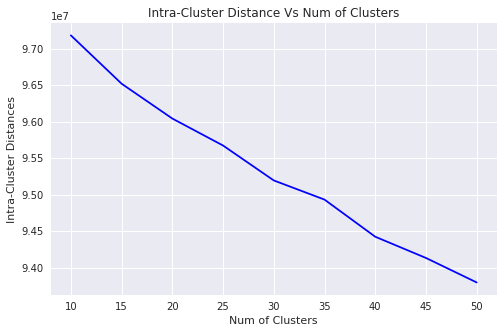

In [270]:
find_best_k(fitted_models)

In [279]:
cluster50 = fitted_models[8]

In [287]:
sorted_data[:100000]['Text'][cluster50.labels_ == 3]

18578     The history of soft drinks goes all the way ba...
10104     I am a soda fan, trying sodas from all over th...
19141     JUICY JUICE'S MISSION: STOP BUYING SODA FOR YO...
19104     TASTES LIKE THIS CAN'T POSSIBLY BE 100% JUICE!...
19020     JUICY JUICE'S MISSION: STOP BUYING SODA FOR YO...
26647     I'm not much of a soda drinker, but I enjoy a ...
77171     A NEW PRODUCT FROM JUICY JUICE IS ANOTHER WINN...
108709    I'm not much of a soda drinker, but I enjoy a ...
102578    Goji juice really does work, but you need to k...
10100     I'm a huge grape soda fan.  The problem is tha...
143967    The Izze Sparkling Grapefruit is a refreshing,...
144174    We have been drinking various forms of flavore...
143929    This review focuses on the pomegranate and gra...
144159    I must say, I am an apple juice fan. My usual ...
144029    I like to pay attention to the glycemic index ...
144188    The Sparkling Clementine Flavor is my favorite...
143867    Izze is a great concept, espec

In [315]:
sorted_data[:100000]['Text'][cluster50.labels_ == 17]

5907      If you've never tried Kona coffee, Aloha Islan...
2294      The grocery store has all kinds of &quot;gourm...
2293      This blend is one of Starbucks' gentler blends...
2941      Many coffee brands that advertise their beans ...
6414      I think that this is a great Chai! Far from sw...
5828      Sometimes you just don't know when you buy thi...
6917      If you like a strong but smooth flavorful coff...
6922      So far ive tried the breakfest blend, columbia...
2241      This coffee rivals the name brand coffee house...
10959     The Douwe Egberts dark roast is the best of al...
10493     I must respectfully disagree with the other re...
10972     Simply because I always get up late and need a...
5019      I am not normally a fan of flavored coffees bu...
6428      I bought a can of this a week ago and it's alr...
19894     An outstanding tea with lots of flavor.  None ...
24724     "This one caught us by surprise! We don't know...
24738     "This one caught us by surpris

In [332]:
sorted_data[:100000]['Text'][cluster50.labels_ == 37]

3403      And it is GOOD!!! You get a half pound of Cots...
361557    I have had products from the Coombs farm in my...
3183      I am allergic to corn, so eating marshmallows,...
4887      Tried this syrup and love it!!!  It tastes lik...
3933      you'll eat this bacon and weep because you'll ...
4842      I have been using Joseph's Lite Syrup for over...
3274      This glorious cheese has changed my life for t...
19475     Pepperidge Farm is one of the few national com...
30988     If you're looking for an easy-to-use pancake m...
23289     I've been dieting for just over a year, using ...
18070     Wow, this stuff is so good. I ordered it after...
4881      Joseph's is the BEST sugar-free maple syrup th...
3309      Excellent taste.  All who partook said it was ...
4872      Excellent taste and texture.  It uses maltitol...
19596     Buy these cookies. You will not regret it.<br ...
10052     I just discovered Barry Farms rice, including ...
10054     I gave it a 4 since I am not u

In [337]:
fitted_models = Hierarchical_cluster(sorted_data.iloc[:5000], count_vect, 'BoW')

In [350]:
cluster10 = fitted_models[8]

In [383]:
sorted_data[:5000]['CleanedText'][cluster10.labels_ == 6]

34743    b'tazo passion herbal infus somewhat tart deep...
3571     b'tazo passion herbal infus somewhat tart deep...
62173    b'tazo chai black tea enjoy chai experi part p...
62205    b'tazo wild sweet orang herbal infus nice oran...
3514     b'tazo calm herbal infus nice chamomil tea tas...
3532     b'tazo chai black tea enjoy chai experi part p...
3594     b'tazo wild sweet orang herbal infus nice oran...
3541     b'tazo china green tip green tea slight strong...
3605     b'tazo zen green tea subtl mild light green te...
3494     b'tazo assort black green tea herbal infus inc...
Name: CleanedText, dtype: object

In [386]:
sorted_data[:5000]['Text'][cluster10.labels_ == 8]

19141    JUICY JUICE'S MISSION: STOP BUYING SODA FOR YO...
19104    TASTES LIKE THIS CAN'T POSSIBLY BE 100% JUICE!...
19020    JUICY JUICE'S MISSION: STOP BUYING SODA FOR YO...
77171    A NEW PRODUCT FROM JUICY JUICE IS ANOTHER WINN...
Name: Text, dtype: object

In [387]:
#Finding TF-IDF vector representation 
tf_idf_vect = TfidfVectorizer(min_df = 0, max_features = 1000)

In [388]:
fitted_models_tfidf = kmean_cluster(sorted_data.iloc[:100000], tf_idf_vect, 'TFIDF')

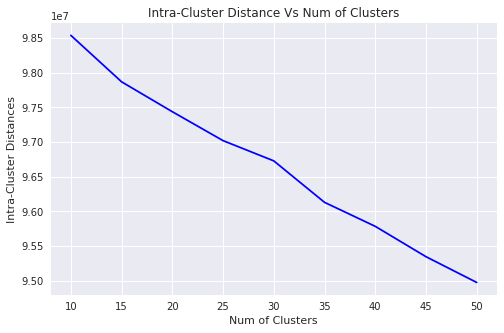

In [389]:
find_best_k(fitted_models_tfidf)

In [390]:
tfidf_cluster50 = fitted_models_tfidf[8]

In [391]:
sorted_data[:100000]['Text'][tfidf_cluster50.labels_ == 3]

1118      Well, maybe not &quot;the&quot; greatest, but ...
7192      These chocolates are the most perfect containe...
12479     I've bought a couple of these for my Airedale ...
21884     My cat loved these! But, I don't know how he e...
126059    Five of my five dogs agree - they'd rather mun...
126057    I've been feeding liver biscotti for years. I ...
2371      My cat LOVES these treats!  There are some tre...
21343     My three dogs love it and so do all the cats!!...
14599     We originally bought this for Sadie, our 75-po...
20627     This review is written for Pill Pockets for Ca...
20854     These are the best for keeping your dog happy!...
126058    A fantastic product for pet treats,great smell...
21509     I am highly recommending you DO NOT give your ...
1008      This is the most unbelievable treat.  My dog w...
90829     ...and I did.  My cat was diagnosed with asthm...
2207      My yorkshie 6 year old can't be fooled...this ...
15219     The Nylabone chews are wonderf

In [394]:
sorted_data[:100000]['Text'][tfidf_cluster50.labels_ == 21]

209365    For me, when the days get colder nothing is as...
5098      Having tried many Jasmine blends, I found the ...
3564      Blend a little apple cider mix into your Tazo ...
6414      I think that this is a great Chai! Far from sw...
3511      For a bag tea--which generally are not as good...
6444      I've tried many of packaged Chai products - li...
3506      "There are few hours in life more agreeable th...
3557      "There is a garden overlooking the Yangtze Riv...
6445      I have searched for a great decaf chai and hav...
3524      "A single cup of Tazo Calm has been known to h...
163001    "Sitting on the porch of a bungalow on a tea p...
76423     I love Sleepytime Tea!  I've been drinking it ...
2987      I recently ordered the Hot Cinnamon Spice tea ...
3559      An incredibly refreshing drink when iced! Mix ...
134994    Sportea is the answer to a healthy daily drink...
2409      When I used to work at the campus pub, one of ...
10221     Mind you, this is my first exc

In [395]:
sorted_data[:100000]['Text'][tfidf_cluster50.labels_ == 49]

6106      For those who enjoy a rich spread for toast, c...
6322      I bought a box of this at the MarketSpice stor...
7635      If you're from the UK or from English colonies...
21676     Given this blend's orgin, the name "English" B...
22816     Introduced to Kenya from India in 1903 by a se...
60858     My search for a good all-purpose decaffeinated...
3310      Since moving to the US from England, there are...
21684     Did you know that the Irish - *not* the Englis...
17555     I had a chance to try these chocolates while i...
20460     Although Dundee's orange marmalade is stocked ...
33909     Did you know that the Irish - *not* the Englis...
20014     Given this blend's orgin, the name "English" B...
26563     I love this tea.  Ahmad tea is just a perfect ...
33911     Among all of Twinings' breakfast teas, this ha...
21682     Irish blend from Twining has a pleasing crisp ...
18175     We went to St. Thomas USVI and this was the on...
3301      Take wonderful rich Double Glo

In [396]:
fitted_models_tfidf = Hierarchical_cluster(sorted_data.iloc[:5000], tf_idf_vect, 'TFIDF')

In [397]:
tfidf_cluster10 = fitted_models_tfidf[8]

In [399]:
sorted_data[:5000]['Text'][tfidf_cluster10.labels_ == 6]

3708      This is the powdered dried cheese like in &quo...
19385     Some of us should be warned about two importan...
19383     Macaroni and Cheese Purists will NOT like this...
20096     I see that someone using my name is advocating...
343931    This stuff is great on rice and beans, and on ...
18611     Parmesan cheese has been a favorite of mine si...
21358     My dog Annie had surgery about 2 months ago an...
25295     I like organic. We do organic milk and meat (a...
25287     I like organic. We do organic milk and meat, a...
19386     I was a kid raised on Kraft macaroni and chees...
25284     We are trying to eat more healthy and organic ...
37054     Annie's Deluxe macaroni and cheese comes with ...
41063     My kids love their Macaroni & Cheese but one d...
37056     My children and I agree: this is the best tast...
36485     This is the best everyone! I can eat the whole...
36759     I absolutely love this mac and cheese it is di...
37074     We stopped buying the Kraft ma

In [402]:
sorted_data[:5000]['Text'][tfidf_cluster10.labels_ == 1]

998       For years I have been trying to simulate a tru...
994       Using the Briel Chamonix machine I purchased f...
1003      After years of using Starbuck's decaf and regu...
2290      Few things I'd like to point out:<p>1.  &quot;...
5907      If you've never tried Kona coffee, Aloha Islan...
2941      Many coffee brands that advertise their beans ...
1005      We ordered these to go with our new espresso m...
6628      Hawaii Roasters is definitely the best coffee ...
6618      I have been drinking coffee for well over twen...
10914     I have been drinking Douwe Egberts red label c...
10967     I am trying to find out if these Senseo pods w...
10679     Douwe Egberts makes some of the most delicious...
10560     The Senseo machine shipped with two 18-pod sam...
10916     The Millstone and Folgers pods for the Home Ca...
10571     After spending 2 weeks in the Netherlands last...
10959     The Douwe Egberts dark roast is the best of al...
10479     On a recent trip to Holland I 

In [12]:
#Importing Libraries 
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [13]:
#Cleaning html tags
def cleanhtml(sentence): 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext

#Cleaning special symbols from texts
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [14]:
#cleaning each text
import re
i = 0
list_of_sent = []
for sent in sorted_data[:100000]['Text'].values:
    filtered_sentence = []
    sent = cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [15]:
#Determining average Word2Vec for each review
def avg_w2v(data, model):
    sent_vectors = []
    for sent in data: 
        sent_vec = np.zeros(100) 
        cnt_words =0; 
        for word in sent: # for each word in a review/sentence
            try:
                vec = model.wv[word]
                sent_vec += vec
                cnt_words += 1
            except:
                pass
        sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return np.matrix(sent_vectors)

In [408]:
fitted_models_w2v = kmean_cluster(list_of_sent, None, 'Word2Vec')

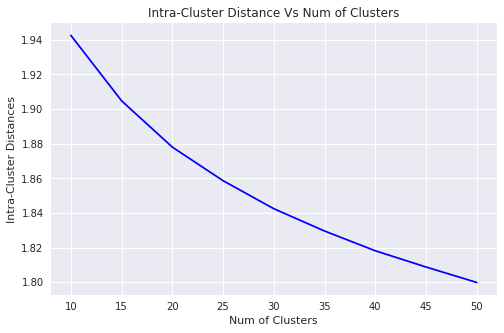

In [409]:
find_best_k(fitted_models_w2v)

In [412]:
w2v_cluster50 = fitted_models_w2v[8]

In [418]:
sorted_data[:100000]['Text'][w2v_cluster50.labels_ == 0]

837       This are so much easier to use than the Wilson...
331       When vacationing Adam and Barbara Maitland mee...
311       When Two Couple (Geena Davis & Alec Baldwin) d...
994       Using the Briel Chamonix machine I purchased f...
3311      The description of a cross between cheddar and...
5919      I have enjoyed Hershey's chocolate bars from t...
3060      Panko bread crumbs are just awesome.  When use...
3385      I surprise myself by rating this cheese my fav...
21885     Boots (the most handsome red tom cat you'll ev...
1398      My cat Foutchie is heading toward 5 now and no...
12997     Most people know that a weakened immune system...
5937      Do you like chewy caramel?  How about chewy ca...
2968      To our taste these chocolates are on a par wit...
156235    Delicious!  Very crunchy and moderately hot.  ...
4664      There are two types of folks in this world - t...
7088      Pickles like these can be very much an acquire...
17644     I bought a Senseo machine for 

In [427]:
sorted_data[:100000]['Text'][w2v_cluster50.labels_ == 21]

6381        I just love this sauce. I put in on everything.
5081      When I First Bought This It Was Huge!There Wer...
11704     I enjoy hot coco and I must say that this is t...
15124     I loved the cake, it was fresh and tasted grea...
2429      I am a huge black licorice fan, however I don'...
13451     I don't recall how we got started on Cholula, ...
17627     Recently purchased Anchovy Stuffed Olives.  It...
10443     What can I say, I just blew my wad with the ti...
9441      I was a little concerned to buy the popcorn, a...
3821      I like this sauce... lots of flavor and high i...
16975     I wish I could rate this  100 stars!!!!  Tey a...
17343     The product that I received is partly vanillin...
20694     I find these at the local asian markets but so...
5824      I am very pleased with my purchase of Gold Mou...
4418      I purchased the item half month ago but I neve...
11016     I first tried this cookie on a Delta flight. I...
5902      I love tea, but I'm VERY picky

In [429]:
fitted_models_w2v = Hierarchical_cluster(list_of_sent[:5000], None, 'Word2Vec')

In [430]:
w2v_cluster10 = fitted_models_w2v[8]

In [439]:
sorted_data[:5000]['Text'][w2v_cluster10.labels_ == 8]

209365    For me, when the days get colder nothing is as...
2993      If you like Earl Grey tea, you'll find no bett...
3564      Blend a little apple cider mix into your Tazo ...
3616      An exquisite black tea with a little extra. If...
12386     There is no gluten free bread out there like t...
2410      Such is the case with this tea.  This mellow y...
2409      When I used to work at the campus pub, one of ...
6339      I had the fortune a couple of years ago to hav...
79705     This kit is a great gift idea and a really goo...
17147     This is a serious espresso. 100% Pure Espresso...
12284     This is not a substitute for brushing your tee...
17636     I have to agree with the guy who complained ab...
8800      The deep purple/red color and hibiscus fragran...
12302     I'm a huge tea fan and was thrilled to see Mel...
2984      So many black teas (such as pu-erh and yunnan)...
9760      This cheese is very different. It has a unique...
161426    If you really want to make an 

In [444]:
sorted_data[:5000]['Text'][w2v_cluster10.labels_ == 5]

245       THIS IS ONE MOVIE THAT SHOULD BE IN YOUR MOVIE...
325       I'm getting crazy.I'm looking for Beatlejuice ...
427       I'm getting crazy.<p>Is it really impossible t...
1032      Although this was a gift to use for keeping wi...
357315    I love meow mix, my cats love it to. We all ea...
2216      I love this stuff. It is sugar-free so it does...
6635      Hawaii Roasters coffee is awesome!!!  I discov...
11974     This is my favorite Earl Grey tea.  My Mom lov...
10964     I have been using the Senseo for some time now...
4429      My daughter is a vegan, so when I bake I use t...
12995     I have been taking amazing grass for about a y...
11128     it is an excellent spread.  nutella and peanut...
3020      This sauce is excellent with somen noodles and...
12869     I think it is Very Expensive  !!<br />I can ge...
16309     So it must be good.  He never lies to me.  Eve...
2429      I am a huge black licorice fan, however I don'...
1473      This is my cat's favorite one.

In [13]:
dbscan = DBSCAN(min_samples=50, p = 2, n_jobs=-1)

In [ ]:
dbscan_w2v = DBSCAN_cluster(list_of_sent[:10000], 'Word2Vec')

In [18]:
len(dbscan_w2v)

4